# Данные

1. <span>&check;</span> Отобрать n тэгов вручную 
2. <span>&check;</span> Собрать первые данные вручную
3. <span>&check;</span> Написать модуль для классификации постов-объявлений о мастерклассе (далее - объявления) 
4. написать модуль для классификации по темам
    - <span>&check;</span> выделить темы
    - разметить данные
    - сделать API модели
5. написать модуль для обновления можества тэгов, множества аккаунтов, постящих объявления

6. Для постов, определенных, как объявления собрать данные о лайках пользователей.


Начало работы с Django
- Сбор данных постов по тэгам в БД (взаимодействие с БД должны осуществлять модели Django)
    - (ML) классификация поста как объявления о проведении мк
    - обновление данных для заданного множества тэгов по расписанию
    - обновление множества тэгов на основании собранных данных
    - логирование
    - тесты



Задачи обработки текста

1. Общие моменты:
    - препроцессинг
    - токенизация
    - анализ

2. Классификация постов о мастерклассе:
- добавить признаки
- делать фильтрацию

3. Выделение тем

In [7]:
import os
import re
import random
from importlib import reload

import pandas as pd
pd.set_option("display.max_rows", 10)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation

from data_utils import data_helper as dahel
from data_utils.preprocessing import TextPreprocessor, FeatureExtractor

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dreps350\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!ls ./data

# Отбор тэгов вручную

In [ ]:
tags = pd.read_csv("./data/main_tags.csv", index_col=0)

In [ ]:
tags.head(20)

# Первые собранные данные:

In [ ]:
%%time

main_data = pd.read_csv("./data/main_posts.csv", sep=";")

In [ ]:
main_data.shape  # (795484, 7)

In [ ]:
main_data.head()

# Отбор постов-объявлений о мастерклассах

- Признак tags сделать множеством
- Убрать тэги из основного текста
- Сделать препроцессинг основого текста (пунктуация, линшние символы)

In [8]:
reload(dahel)

fext = FeatureExtractor()

In [4]:
# %%time

# workshops_data = main_data.pipe(fext.filter_workshops)
# workshops_data.to_csv("./data/main_workshops.csv", sep=";", index=False)

In [9]:
workshops_data = pd.read_csv("./data/main_workshops.csv", sep=";")

In [10]:
workshops_data = workshops_data.pipe(fext._add_tags)

In [11]:
workshops_data.shape  #(37461, 10)

(37482, 11)

In [12]:
workshops_data.head()

,post_id,text,date,likes,owner_id,is_video,by_tag,phone_number,direct,price,tags
0,3-9jrIxI65,"@damarkelova ・・・\r\r\nДоброе утро, друзья!! От...",1.434444e+09,199,1.101804e+09,False,акварельмк,89037727778,NaN,2200,"{досуг, workshop, акварель, мастеркласс, досуг..."
1,3vos8XRI98,"Вечером в среду, после обеда...\r\r\nЖдем вас ...",1.433930e+09,152,1.101804e+09,False,акварельмк,89037727778,NaN,2200,"{цветы, workshop, мастеркласспоакварели, аквар..."
2,3vxZIas4-H,#Repost @culture_club with @repostapp.\r\r\n・・...,1.433935e+09,36,1.132830e+07,False,акварельмк,89037727778,NaN,2200,"{цветы, workshop, мастеркласспоакварели, аквар..."
3,6ey5mMh57E,"Как и обещали, с радостью представляем вам нов...",1.439807e+09,9,9.591155e+08,False,акварельмк,8-963-328-37-28,NaN,2000,"{рисуемакварельюшедевры, акварели, ботаника, р..."
4,BhRt7-NF6lS,💞 Дорогие подписчики 💞\r\r\n.\r\r\n🌸 21 апреля...,1.523120e+09,50,1.909118e+09,False,акварельмк,7951-677-6710,NaN,2500,"{петроградская, школарисования, сергейзиновкин..."


# Классификация по темам

В качестве признаков используем хэш-тэги

Поскольку изначально существующие темы неизвестны, для начала используем кластеризацию и преобразование Дирихле для выделения тем и ручной разметки данных.

## Токенизация хэш тэгов своим парсером

In [ ]:
# \ обозначает, что ключевое слово может стоять только в конце или начале тэга

key_words = {
    "мастеркласс",
    "\\мк",
    "курс",
    "своимируками",
    "кудаго",
    "кудапойти",
    "кудасходить",
    "обучение"
}

In [ ]:
workshops_with_tags = (workshops_data.pipe(fext._add_tags, 
                                           pattern="kw_tag", 
                                           key_words=key_words)
                                     .pipe(fext._add_stripped_tags, key_words=key_words))

In [ ]:
workshops_with_tags["stripped_tags"]

In [ ]:
!ls ./data

In [ ]:
example = np.random.choice(workshops_with_tags["stripped_tags"].values, 10)

with open("./data/stopwords-ru.txt", encoding="utf-8") as f:
    stop_words = set(f.read().splitlines())

In [ ]:
example

## Токенизация хэш тэгов с помощью вероятностного подхода

https://nbviewer.jupyter.org/url/norvig.com/ipython/How%20to%20Do%20Things%20with%20Words.ipynb

##### Идеи:
- города использовать с лемматизацией

In [13]:
%%time

fc = dahel.FreqCounter().fit(workshops_data['text'])
fc_tags = dahel.FreqCounter().fit(workshops_data['text'], pattern="any_tag")

Wall time: 11.4 s


In [14]:
fc._freqs.__len__(), fc_tags._freqs.__len__()  # (156145, 41489)

(156123, 41459)

Для того чтобы иметь возможность правильно разделять слитно написанные тэги, необходимо иметь распределение вероятностей реальных слов - считаем частоты всех слов без тэгов

In [ ]:
c = fc._freqs - fc_tags._freqs

Для того чтобы хорошо отделять специальные слова, например названия городов, искусственxно добавляем им высокие частоты

In [15]:
cities = pd.read_csv("./data/cities_.csv", sep=";", header=None)[1]
cities.head()

0           москва
1        абрамцево
2          алабино
3        апрелевка
4    архангельское
Name: 1, dtype: object

In [16]:
cities_freqs = {city: 100 for city in cities.values}

Дополнительно можно добавить несколько слов вручную

In [17]:
special_words = pd.read_csv("./data/special_words.csv", sep=";", header=None)[1]
special_words.head()

0        питер
1          спб
2    петроград
3     петергоф
4     аэробика
Name: 1, dtype: object

In [18]:
sp_words_freqs = {word: 100 for word in special_words}

In [19]:
c.update(cities_freqs)
c.update(sp_words_freqs)
len(c)

128338

In [20]:
n_rows, max_rows = 0, 10
for word, freq in c.items():
    if n_rows > max_rows:
        break
    print("Word %s frequency is %s" % (word, freq))
    n_rows += 1

Word вчера frequency is 104
Word мы frequency is 8001
Word тех frequency is 3670
Word досуг frequency is 66
Word 2200руб frequency is 13
Word скидка frequency is 1510
Word и frequency is 31643
Word завтра frequency is 782
Word mail frequency is 816
Word не frequency is 13590
Word утро frequency is 519


Препроцессинг слов в тэгах:
- убрать стоп-слова (использовать множества)
- убрать слишком короткие слова (неверные разбиения)
- привести к нормальной форме (pymorphy)

Собраем текстовые данные из полей <em>text</em> и <em>tags</em>

In [ ]:
# сравнить результаты с лемматизатором и стеммером
# from nltk.stem.snowball import SnowballStemmer 

# stemmer = SnowballStemmer("russian") 

In [22]:
tag_pos = {"ADJF", "NOUN"}

In [48]:
not_tag_pat = "(?<!\S)[а-я]+(?!\S)"

In [51]:
%%time

test_text_data = TextPreprocessor(token=not_tag_pat, allowed_pos=tag_pos).transform(workshops_data["text"].head())

Wall time: 110 ms


In [52]:
test_text_data[0]

['добрый',
 'дорога',
 'огромный',
 'букет',
 'турецкий',
 'ботанический',
 'иллюстрация',
 'запись',
 'весь',
 'информация',
 'июнь',
 'стоимость',
 'весь',
 'материал',
 'боевой',
 'дружеский']

In [55]:
%%time

text_data = TextPreprocessor(token=not_tag_pat, allowed_pos=tag_pos).transform(workshops_data["text"])

Wall time: 8min 37s


In [56]:
text_data[0]

['добрый',
 'дорога',
 'огромный',
 'букет',
 'турецкий',
 'ботанический',
 'иллюстрация',
 'запись',
 'весь',
 'информация',
 'июнь',
 'стоимость',
 'весь',
 'материал',
 'боевой',
 'дружеский']

In [29]:
workshops_data["tags"]

0        {досуг, workshop, акварель, мастеркласс, досуг...
1        {цветы, workshop, мастеркласспоакварели, аквар...
2        {цветы, workshop, мастеркласспоакварели, аквар...
3        {рисуемакварельюшедевры, акварели, ботаника, р...
4        {петроградская, школарисования, сергейзиновкин...
                               ...                        
37477    {украшенияназаказ, металклэй, ювелир, серебро,...
37478    {украшенияназаказ, металклэй, ювелир, серебро,...
37479                     {ювелирныймастеркласс, jakjoten}
37480                               {ювелирныймастеркласс}
37481                               {ювелирныймастеркласс}
Name: tags, Length: 37482, dtype: object

In [108]:
%%time
# поправить токенизацию
tags_data = TextPreprocessor(mode="nospace", counter=c, allowed_pos=tag_pos).transform(workshops_data["tags"].str.join(" "))

Wall time: 2min 7s


# Выделение тем при помощи кластеризации тэгов

In [113]:
%%time

vect_params = {
#     "ngram_range": (1, 2),
#     "analyzer": "char_wb",
    "max_df": .95,
    "min_df": 2,
}

class NoTokenTfidfVect(TfidfVectorizer):
    def build_analyzer(self):
        return lambda x: x

tfidf = NoTokenTfidfVect(**vect_params)
X = tfidf.fit_transform(text_data+tags_data)

Wall time: 796 ms


In [114]:
X

<37482x15231 sparse matrix of type '<class 'numpy.float64'>'
	with 1247485 stored elements in Compressed Sparse Row format>

In [59]:
%%time

km = MiniBatchKMeans(random_state=17)
km.fit(X)

Wall time: 284 ms


In [62]:
kma = dahel.KMeansAnalizer(km, X, verbose=True)

kma.explore(range(2, 20))

fitting 2 clusters
fitting 3 clusters
fitting 4 clusters
fitting 5 clusters
fitting 6 clusters
fitting 7 clusters
fitting 8 clusters
fitting 9 clusters
fitting 10 clusters
fitting 11 clusters
fitting 12 clusters
fitting 13 clusters
fitting 14 clusters
fitting 15 clusters
fitting 16 clusters
fitting 17 clusters
fitting 18 clusters
fitting 19 clusters


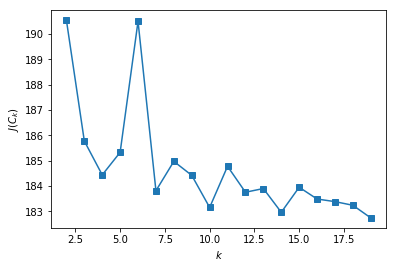

In [63]:
kma.plot_inertia()

In [115]:
km1 = MiniBatchKMeans(n_clusters=15, random_state=17)
km1.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=15,
        n_init=3, random_state=17, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [ ]:
# clustered_tags = new_ws_data.assign(labels=km1.labels_).groupby("labels")["splitted_tags"].apply(lambda x: set().union(*x))

# for c in clustered_tags:
#     print(c, end="\n\n")

Слова, характеризующие выделенные кластеры.

In [116]:
order_centroids = km1.cluster_centers_.argsort()[:, ::-1]

terms = tfidf.get_feature_names()
for i in range(15):
    print("Cluster %d:" % (i + 1), end='')
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 1: макияж бровь визажист окрашивание спб модель хна ламинирование коррекция запись услуга курс форма отработка визаж
Cluster 2: ребёнок новогодний год занятие декабрь весь стоимость свой детский запись венка наш новый подарок ваш
Cluster 3: спб весь запись стоимость директ свой рубль декупаж наш арт материал который питер день москва
Cluster 4: рисование масло занятие живопись школа наш сантиметр картина абонемент холст художник сайт репост обучение акварель
Cluster 5: торт кондитер кондитерский курс кондитерская москва мк кондитерские шоколад шоколадный школа крем домашняя начинка кулинарные
Cluster 6: картина живопись масло арт весь рисование холст художник стоимость акрил свой рисуем творчество занятие запись
Cluster 7: новосибирск живопись масло курсы афиша курс гончарная холст рисую личка гончарные детские керамический роспись обжиг
Cluster 8: оплата сайт час рабочий минута метро мир человек арт описание масло время творчество навык активный
Cluster 9: урок концерт съёмка 

# Выделение тем с использованием латентного размещения Дирихле

In [98]:
cv_params = {
    "max_df": 0.95,
    "min_df": 2,
    "max_features": 5000
}

lda_params = {
    "n_components": 20,
    "max_iter": 10,
    "learning_method": "online",
    "learning_offset": 50.,
}

class CustomCV(CountVectorizer):
    def build_analyzer(self):
        return lambda x: x

class ProcessLDA:
    
    def __init__(self, cv_params, lda_params, random_state=17):
        self.random_state = random_state
        self.text_vect = CustomCV(**cv_params)
        self.lda = LatentDirichletAllocation(**lda_params)

    def fit(self, data):
        X = self.text_vect.fit_transform(data)
        self.lda.fit(X)
        self.feature_names = tfidf.get_feature_names()
        return self
    
    def print_top_words(self, n_top_words):
        for topic_idx, topic in enumerate(self.lda.components_):
            message = "Topic #%d: " % topic_idx
            message += " ".join([self.feature_names[i]
                                 for i in topic.argsort()[:-n_top_words - 1:-1]])
            print(message)
        print()

In [111]:
%%time

lda = ProcessLDA(cv_params, lda_params).fit(text_data+tags_data)

Wall time: 1min 9s


In [102]:
text_data

0        [добрый, дорога, огромный, букет, турецкий, бо...
1                [запись, стоимость, весь, боевой, скидка]
2                [запись, стоимость, весь, боевой, скидка]
3        [радость, новое, талантливый, художница, сентя...
4        [дорогой, подписчик, акварельный, портрет, сер...
                               ...                        
37477    [работа, инструктор, российский, школа, ольга,...
37478    [работа, инструктор, российский, школа, ольга,...
37479    [ювелирный, рубль, стоимость, октябрь, конец, ...
37480    [наш, любимый, ученик, будущий, хороший, новый...
37481    [наш, суперпредложение, самый, время, обручаль...
Name: text, Length: 37482, dtype: object

In [112]:
lda.print_top_words(20)

Topic #0: выдержанна изба запоздание возможность идея вознесенский креативность горло гусев возможный кренделёк кремлёвский вознаграждение ацетатный выезд идеальность категория запоминательность входной земляничный
Topic #1: детка комфортный бюджетный крутой замечательный давление грань базилик джаз крупяной кисловодск компактность коттедж добрый байбурина ацетатный аккуратность кувшинка витрина больница
Topic #2: категория абсолюный золотистый колорит вечерний какао евтеева верёвочка гавайск бюджетный демьян дип индеец веселие картонаж гусев калашников глазковый вис ароматизация
Topic #3: автобус акрил гендерный корректирование гиалуроновый зульфия карина кальмар десяток аппликация аэропорт извилистый канун актив динара баночка бюджетный комод автографсессия горстка
Topic #4: гитара буйство зубков видеоурок акрил коростовцев корректирование креативность автоматический бьютиблогер котлетка карне атмосфера корректив кинотеатр глава зубок глазурь европейский аттракцион
Topic #5: кафедра 

# На основе результатов кластеризации и латендного размещение Дирихле создаем словать для разметки данных

In [ ]:
topics = {
    "живопись": {"масло", "картина", "живопись", "художник", "акварель", "акрил", "рисование"},
    "фотография": {"фотография", "фотограф", "фотосъёмка", "фотосессия"},
    "лепка": {"глина", "лепка", "полимерный", "лепить"},
    "ювелирное_дело": {"ювелирный", "бижутерия", "ювелир", "брошь"},
    "вязание": {"вязание", "вязаный", "крючок", "спица", "трикотажнаяпряжа"},
    "шитьё": {"шитьё", "нитки"},
    "кулинария": {"торт", "пряник", "десерт", "кулинарный", "кондитерский", "кухня", "еда", "дегустация", "повар"},
    "флористика": {"флористика", "букет", "цветок", "цветочный", "флорист", "флорариум"},
    "красота_и_здоровье": {"макияж", "стилист", "визажист", "стрижка"},
    "детский": {"ребёнок", "детский"},
    "валяние": {"валяние"},
    "музыка": {"концерт", "музыка", "концертный", "клип", "песня", "кавер"},
    "декор": {"декупаж", "декор"}
}

def _map_tag_topics(tags: "set"):
    res = set()
    for tpc, map_tags in topics.items():
        if map_tags & tags:
            res.add(tpc)
    return res

def _map_text_topics(text):
    res = set()
    for tpc, words in topics.items():
        for w in words:
            if w in text:
                res.add(tpc)
    return res

def _map_topics(row: "pd.Series"):
    res = set()
    for tpc, words in topics.items():
        if words & row["tags"]:
            res.add(tpc)
        for w in words:
            if w in row["text"]:
                res.add(tpc)
    return res

In [ ]:
workshops_data.head()

In [ ]:
text_data

In [ ]:
text_data["text"] = text_data["text"] + tags_data

In [ ]:
text_data["topics"] = text_data['text'].map(_map_text_topics)

In [ ]:
ts.segment("плетеныесумкиопт")

In [ ]:
np.random.choice(text_data[text_data["topics"]==set()]["text"], 10)

In [ ]:
workshops_data["tags"].map(_map_tag_topics)

In [ ]:
%%time

workshops_data["topics"] = workshops_data.apply(_map_topics, axis=1)

In [ ]:
m.parse(workshops_data[workshops_data.topics == set()]["text"].iloc[0])

In [ ]:
workshops_data[workshops_data.topics == set()]["text"].iloc[100]

In [ ]:
new_ws_data["topic"] = new_ws_data["splitted_tags"].map(_map_topics)

In [ ]:
new_ws_data[new_ws_data["topic"].map(lambda x: x==[])]

# old

In [ ]:
# from pymorphy2 import MorphAnalyzer

In [ ]:
# NOSPACE = dahel.NoSpaceSplitter(c)
# MORPH = MorphAnalyzer()
# my_stop_words = {
#     "мастеркласс",
#     "мастер",
#     "класс",
#     "мк",
# }
# STOPWORDS = set(stopwords.words("russian")).union(my_stop_words)


# class TextPreprocessor:
                
#     def __init__(self, mode="normal", token="[а-я]+", allowed_pos=None):
#         if mode not in {"normal", "nospace"}:
#             raise ValueError("Unknown mode.")
#         self.mode = mode
#         self.token = token
#         self.allowed_pos = allowed_pos
                
#     def _tokenize(self, doc):
#         return re.findall(self.token, doc)
    
#     def _clear_stop_words(self, doc):
#         return [w for w in doc if w not in STOPWORDS]
    
#     def _lemmatize(self, doc):
#         res = []
#         for w in doc:
#             parsed = MORPH.parse(w)[0]
#             if self.allowed_pos:
#                 if parsed.tag.POS in self.allowed_pos:
#                     res.append(parsed.normal_form)
#                 else:
#                     continue
#             else:
#                 res.append(parsed.normal_form)
#         return res

#     def _no_space_split(self, doc):
#         res = []
#         for w in doc:
#             split = NOSPACE.segment(w)
#             if len(split) <= 2:
#                 res.extend(split)
#         return res
    
#     def _preprocess(self, corpora):
#         data = (corpora.str.lower()
#                         .map(self._tokenize)
#                         .map(self._lemmatize)
#                         .map(self._clear_stop_words))
#         return data

#     def transform(self, corpora: "pd.Series"):
#         if self.mode == "normal":
#             return self._preprocess(corpora)
#         elif self.mode == "nospace":
#             return self._preprocess(corpora).map(self._no_space_split)

In [ ]:
def pdist(counter):
    "Make a probability distribution, given evidence from a Counter."
    N = sum(counter.values())
    return lambda x: counter[x]/N

P = pdist(c)

In [ ]:
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product((P(w) for w in words))

def product(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in nums:
        result *= x
    return result

In [ ]:
def memo(f):
    "Memoize function f, whose args must all be hashable."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
#     fmemo.cache = cache
    return fmemo

def splits(text, start=0, L=20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

@memo
def segment(text):
    "Return a list of words that is the most probable segmentation of text."
    if not text: 
        return []
    
    candidates = [[first] + segment(rest) 
                  for (first, rest) in splits(text, 1)]
    res = sorted(candidates, key=Pwords, reverse=True)
    
    return res[0]
#     return candidates

In [ ]:
# pat = re.compile("#(\w*мастеркласс\w*|мк\w*|\w*мк)(?=[#\W]|$)")
def prepare_pat(key_words):
    res = []
    for kw in key_words:
        res.append(r"\w*{}\w*".format(kw))
    
    special = [r"мк\w*", r"\w*мк"]
    res.extend(special)
    
    tags_pat = "|".join(res)
    
    return re.compile(r"#({})(?=[#\W]|$)".format(tags_pat))

In [ ]:
pat1 = prepare_pat(key_words)

In [ ]:
pat1

In [ ]:
# cities = pd.read_csv("./data/city.csv", sep=";")["name"]
# cities = cities.str.lower().str.replace("-", "")
# cities_tags = [
#     "спб",
#     "питер",
#     "петербург",
#     "екб",
#     "мск"
# ]
# pd.concat([cities, pd.Series(cities_tags)], ignore_index=True).to_csv("./data/cities_.csv", sep=";")